In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 4.29 μs


In [3]:
# configuration settings
data_root = '../data/phantom_lung2_0'
mesh_version = 10
num_levels = 3
num_conv_layers = 2
conv_channels = 8
conv_kernel_size = 3
output_func = 'relu'
batch_size = 1
learning_rate = 1e-5
interp_size = 5
interp_type = 'tent'
rho_value = 0

save_every = 10
save_prefix = '2024-11-15__lung2/asdf'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'
load_epoch = 0

Loading ../data/phantom_lung2_0/phantom5/phantom5_anat.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_elast.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_disp.nii.gz
Loading ../data/phantom_lung2_0/phantom5/phantom5_mask.nii.gz
CT


<IPython.core.display.Javascript object>


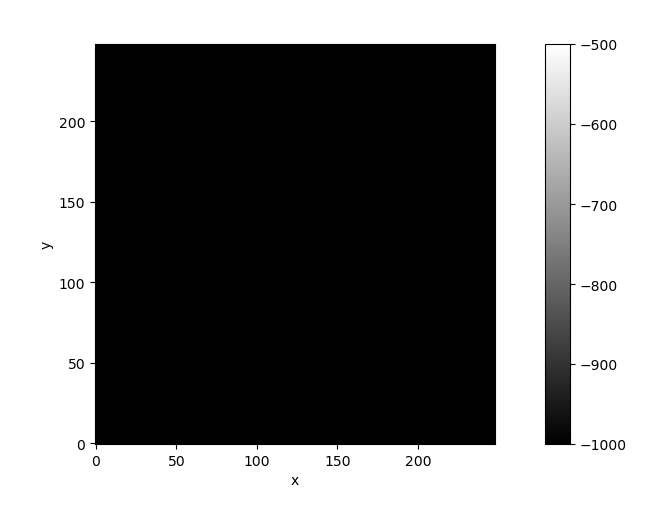

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

elasticity


<IPython.core.display.Javascript object>


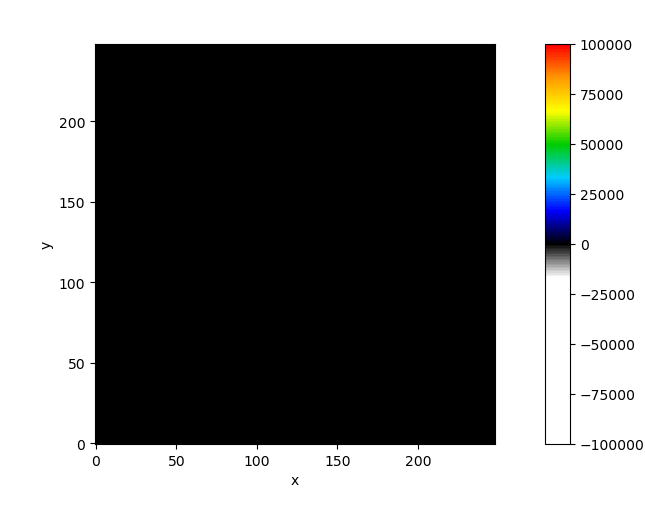

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

displacement


<IPython.core.display.Javascript object>


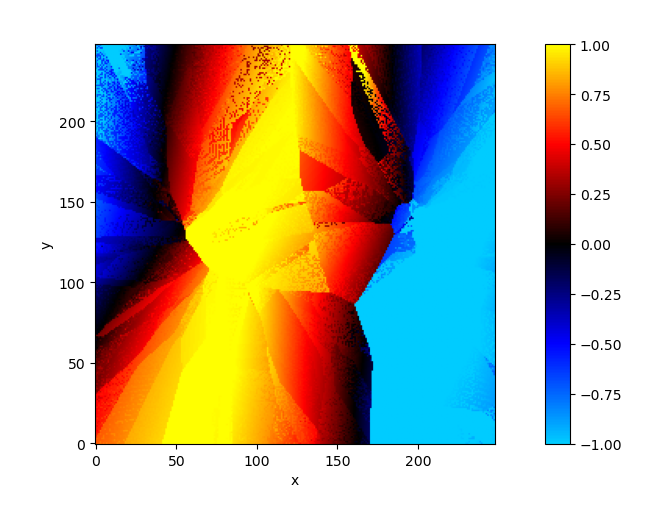

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

Loading ../data/phantom_lung2_0/phantom5/phantom5_mesh10.xdmf
Loading ../data/phantom_lung2_0/phantom5/phantom5_mesh10.xdmf... 5070


In [4]:
%autoreload
phantom_set = project.phantom.PhantomSet(data_root, num_phantoms=100)
phantom = phantom_set[5]
phantom.load_niftis()
project.visual.XArrayViewer(phantom.anat)
project.visual.XArrayViewer(phantom.elast)
project.visual.XArrayViewer(phantom.disp)
phantom.load_mesh(10)
phantom.mesh

In [5]:
all_examples = phantom_set.get_examples(mesh_version)
train_examples = all_examples[10:]
test_examples = all_examples[:10]
len(train_examples), len(test_examples)

(90, 10)

In [6]:
all_examples[0]

{'name': 'phantom0',
 'anat_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_anat.nii.gz'),
 'elast_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_elast.nii.gz'),
 'disp_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_disp.nii.gz'),
 'mask_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_mask.nii.gz'),
 'mesh_file': PosixPath('../data/phantom_lung2_0/phantom0/phantom0_mesh10.xdmf')}

In [7]:
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [8]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
).cuda()

In [16]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    save_every=save_every,
    save_prefix=save_prefix,
    sync_cuda=True
)

In [17]:
load_epoch = 100
if load_epoch:
    trainer.load_state(epoch=load_epoch)

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../project/training.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)
/oc

Loading ../data/phantom_lung2_0/phantom7/phantom7_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom7/phantom7_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom7/phantom7_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom7/phantom7_mesh10.xdmf... 5324
Loading ../data/phantom_lung2_0/phantom7/phantom7_elast.nii.gz... (256, 256, 94)
['phantom7'].

<IPython.core.display.Javascript object>


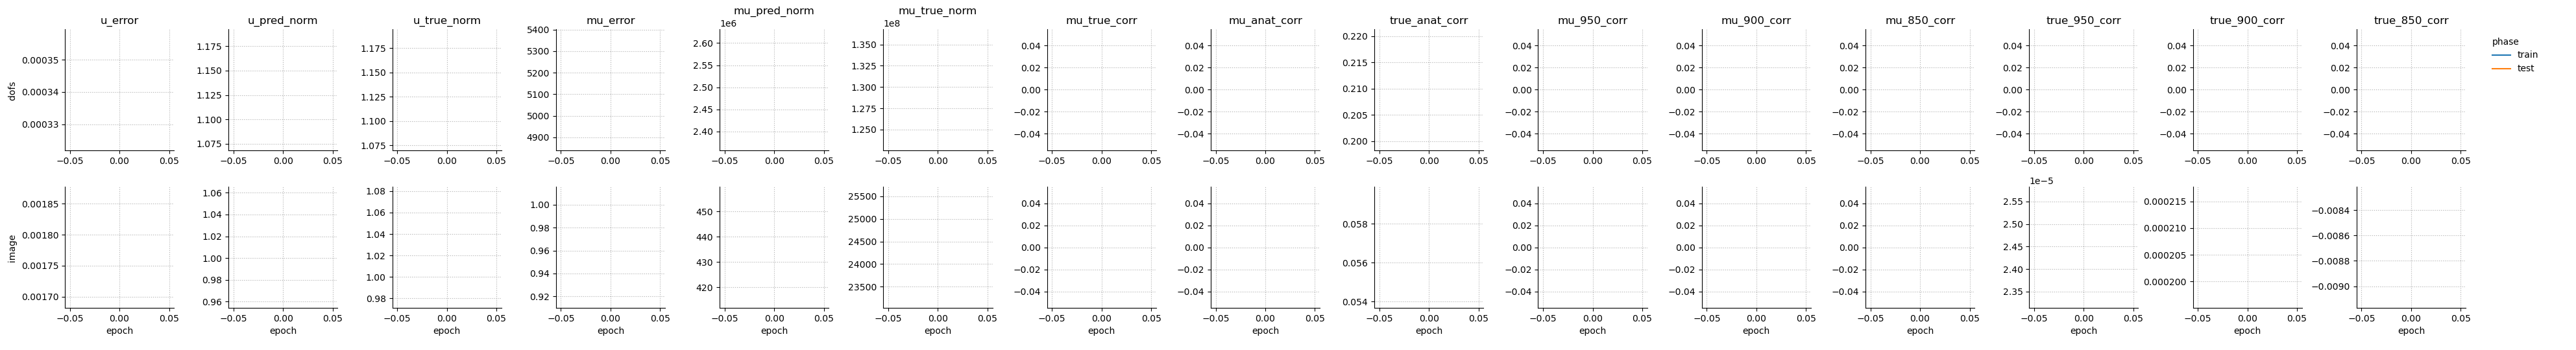

anat


<IPython.core.display.Javascript object>


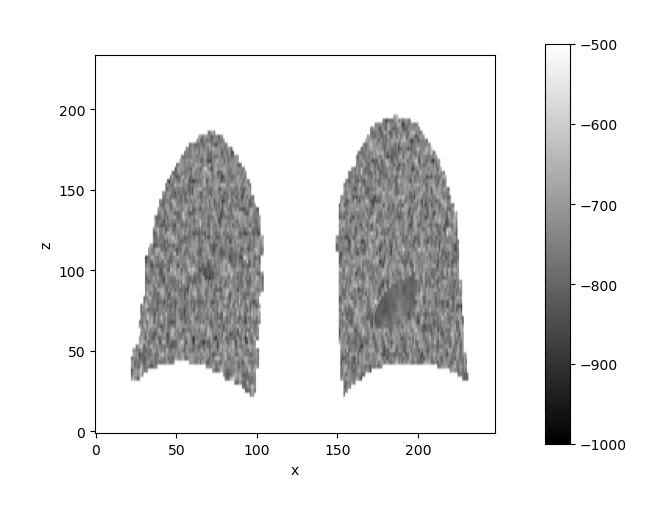

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

emph


<IPython.core.display.Javascript object>


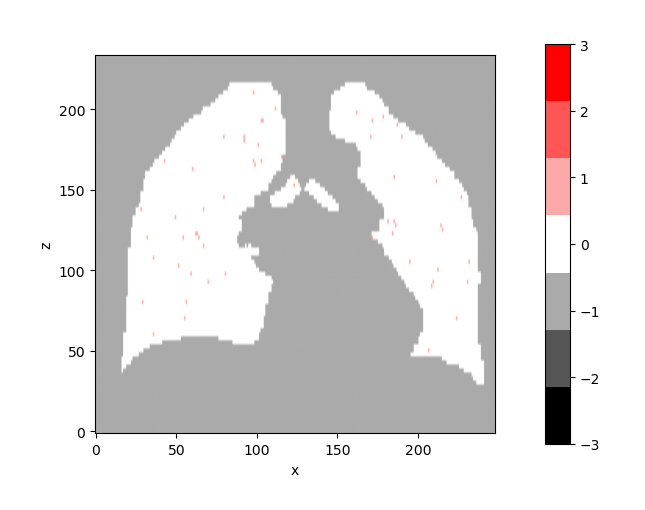

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

e_pred


<IPython.core.display.Javascript object>


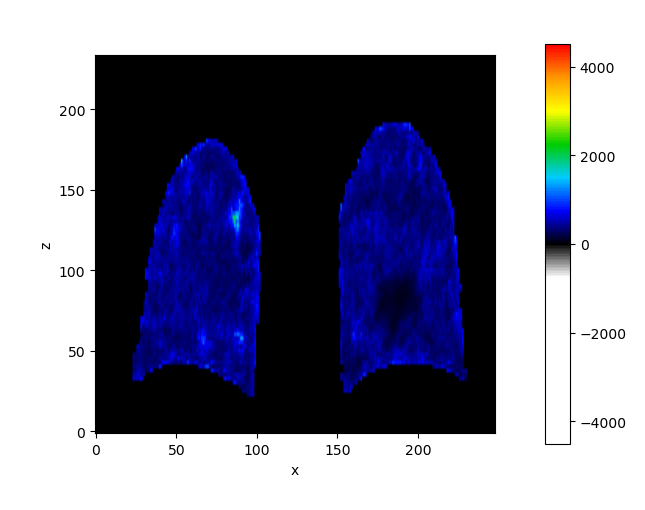

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

e_true


<IPython.core.display.Javascript object>


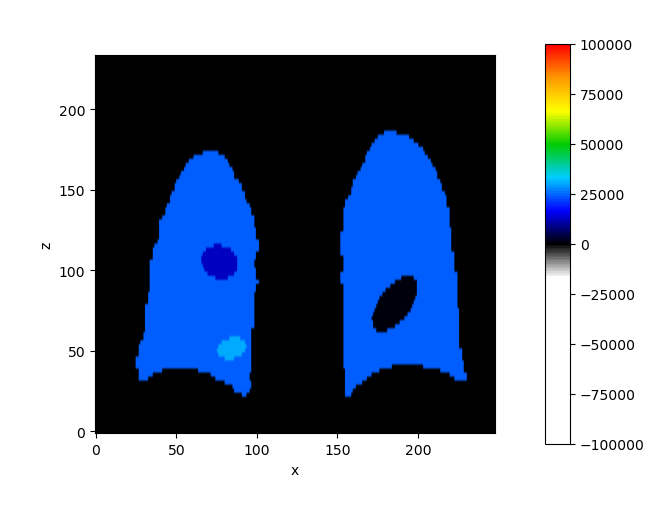

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

u_pred


<IPython.core.display.Javascript object>


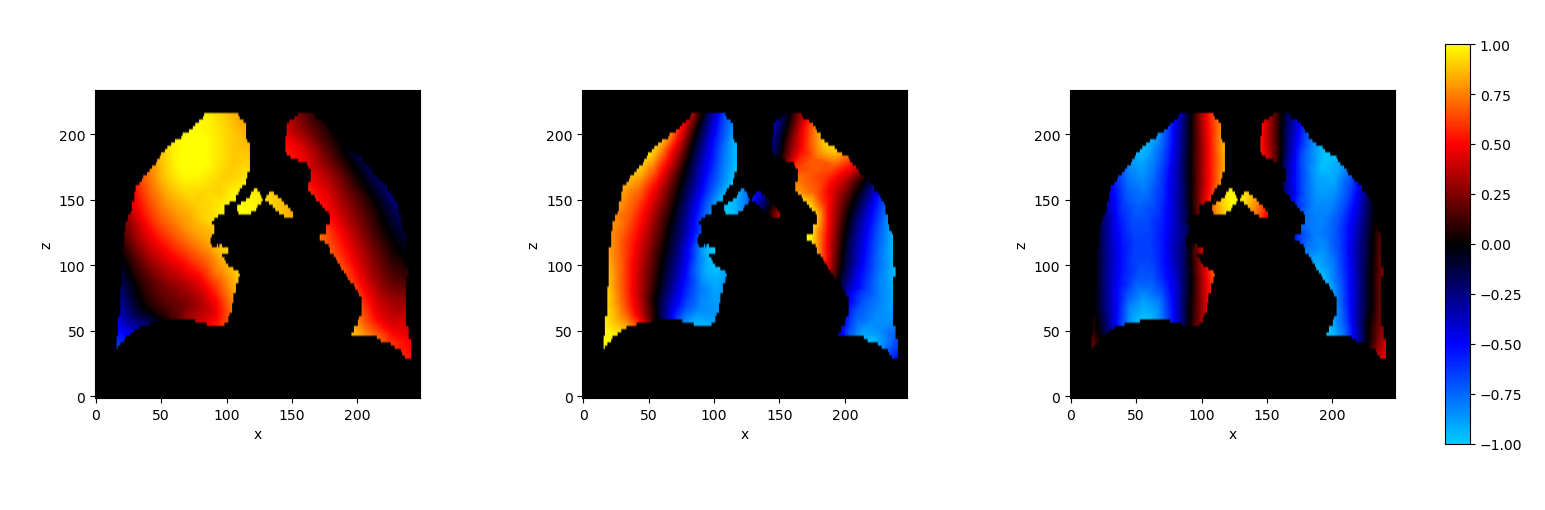

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

u_true


<IPython.core.display.Javascript object>


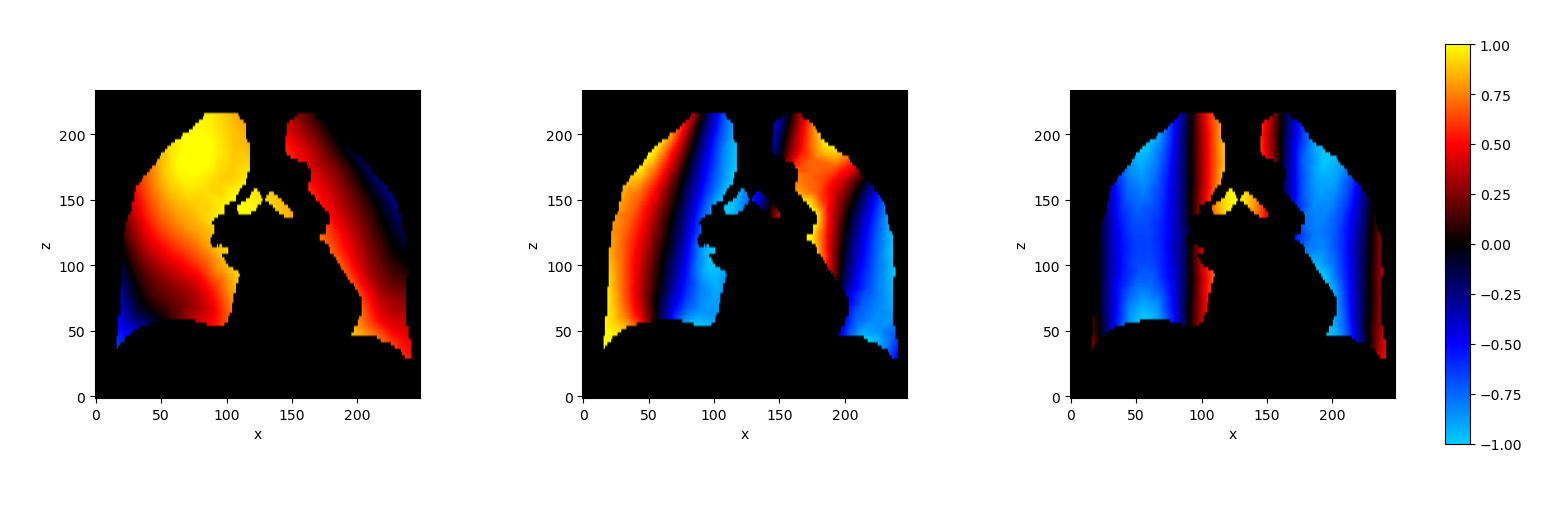

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

0.0003
CPU times: user 2min 26s, sys: 955 ms, total: 2min 27s
Wall time: 2min 24s


In [18]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=0)

In [22]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=100)

Training...
Epoch 1/100
Running train phase
['phantom34'].0.0007
Loading ../data/phantom_lung2_0/phantom45/phantom45_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom45/phantom45_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom45/phantom45_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom45/phantom45_mesh10.xdmf... 5294
Loading ../data/phantom_lung2_0/phantom45/phantom45_elast.nii.gz... (256, 256, 94)
['phantom45'].0.0021
Loading ../data/phantom_lung2_0/phantom92/phantom92_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom92/phantom92_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom92/phantom92_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom92/phantom92_mesh10.xdmf... 5128
Loading ../data/phantom_lung2_0/phantom92/phantom92_elast.nii.gz... (256, 256, 94)
['phantom92'].0.0308
Loading ../data/phantom_lung2_0/phantom53/phantom53_anat.nii.gz... (256, 256, 94)
Loa

Loading ../data/phantom_lung2_0/phantom51/phantom51_elast.nii.gz... (256, 256, 94)
['phantom51'].0.0031
Loading ../data/phantom_lung2_0/phantom54/phantom54_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom54/phantom54_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom54/phantom54_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom54/phantom54_mesh10.xdmf... 5278
Loading ../data/phantom_lung2_0/phantom54/phantom54_elast.nii.gz... (256, 256, 94)
['phantom54'].0.0011
Loading ../data/phantom_lung2_0/phantom93/phantom93_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom93/phantom93_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom93/phantom93_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom93/phantom93_mesh10.xdmf... 5256
Loading ../data/phantom_lung2_0/phantom93/phantom93_elast.nii.gz... (256, 256, 94)
['phantom93'].0.0008
['phantom81'].0.0006
Loading ../data/phantom_l

Loading ../data/phantom_lung2_0/phantom29/phantom29_mesh10.xdmf... 4968
Loading ../data/phantom_lung2_0/phantom29/phantom29_elast.nii.gz... (256, 256, 94)
['phantom29'].0.0005
['phantom57'].0.0005
Loading ../data/phantom_lung2_0/phantom61/phantom61_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom61/phantom61_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom61/phantom61_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom61/phantom61_mesh10.xdmf... 5019
Loading ../data/phantom_lung2_0/phantom61/phantom61_elast.nii.gz... (256, 256, 94)
['phantom61'].0.0077
Loading ../data/phantom_lung2_0/phantom30/phantom30_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom30/phantom30_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom30/phantom30_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom30/phantom30_mesh10.xdmf... 5107
Loading ../data/phantom_lung2_0/phantom30/phantom30_elast

Loading ../data/phantom_lung2_0/phantom96/phantom96_mesh10.xdmf... 5210
Loading ../data/phantom_lung2_0/phantom96/phantom96_elast.nii.gz... (256, 256, 94)
['phantom96'].0.0017
['phantom72'].0.0010
Loading ../data/phantom_lung2_0/phantom8/phantom8_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom8/phantom8_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung2_0/phantom8/phantom8_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung2_0/phantom8/phantom8_mesh10.xdmf... 5454
Loading ../data/phantom_lung2_0/phantom8/phantom8_elast.nii.gz... (256, 256, 94)
['phantom8'].0.0001
Epoch 2/100
Running train phase
['phantom64'].0.0008
['phantom74'].0.0003
['phantom35'].0.0037
['phantom22'].0.0016
['phantom84'].0.0386
['phantom75'].0.0003
['phantom83'].0.0007
['phantom98'].0.0011
['phantom60'].0.0021
['phantom13'].0.0003
['phantom45'].0.0025
['phantom57'].0.0005
['phantom25'].0.0058
['phantom90'].0.0007
['phantom53'].0.0009
['phantom69'].0.0010
['phantom27'].0.0002


['phantom77'].0.0007
['phantom66'].0.0062
['phantom10'].0.0027
['phantom54'].0.0004
['phantom18'].0.0010
['phantom37'].0.0006
['phantom49'].0.0012
['phantom22'].0.0011
['phantom14'].0.0045
['phantom31'].0.0017
['phantom95'].0.0022
['phantom47'].0.0025
['phantom84'].0.0155
['phantom43'].0.0009
['phantom63'].0.0008
['phantom93'].0.0006
['phantom83'].0.0006
['phantom67'].0.0010
['phantom35'].0.0019
['phantom74'].0.0002
['phantom91'].0.0026
['phantom36'].0.0006
['phantom99'].0.0015
['phantom80'].0.0057
['phantom19'].0.0026
['phantom26'].0.0009
['phantom24'].0.0033
['phantom48'].0.0004
['phantom30'].0.0006
['phantom68'].0.0005
['phantom87'].0.0006
['phantom11'].0.0004
['phantom79'].0.0015
['phantom57'].0.0004
['phantom90'].0.0008
['phantom62'].0.0004
['phantom69'].0.0006
['phantom72'].0.0007
['phantom28'].0.0005
['phantom17'].0.0063
['phantom56'].0.0059
['phantom52'].0.0004
['phantom98'].0.0010
['phantom86'].0.0005
['phantom51'].0.0035
['phantom61'].0.0032
['phantom71'].0.0020
['phantom32']

['phantom53'].0.0006
['phantom44'].0.0023
['phantom79'].0.0012
['phantom33'].0.0015
['phantom62'].0.0003
['phantom50'].0.0005
['phantom59'].0.0003
['phantom25'].0.0007
['phantom86'].0.0004
['phantom10'].0.0018
['phantom64'].0.0007
['phantom95'].0.0011
['phantom22'].0.0011
['phantom90'].0.0005
['phantom66'].0.0039
['phantom87'].0.0004
['phantom93'].0.0005
['phantom30'].0.0005
['phantom29'].0.0004
['phantom46'].0.0016
['phantom89'].0.0048
['phantom48'].0.0005
['phantom76'].0.0007
['phantom55'].0.0005
['phantom92'].0.0029
['phantom54'].0.0004
['phantom52'].0.0003
['phantom75'].0.0002
['phantom20'].0.0013
['phantom37'].0.0005
['phantom97'].0.0010
['phantom41'].0.0039
['phantom35'].0.0014
['phantom17'].0.0043
['phantom96'].0.0009
['phantom81'].0.0004
['phantom82'].0.0001
['phantom74'].0.0002
['phantom60'].0.0010
['phantom11'].0.0004
['phantom42'].0.0002
['phantom83'].0.0005
['phantom99'].0.0006
['phantom15'].0.0003
['phantom72'].0.0005
['phantom45'].0.0006
['phantom47'].0.0021
['phantom28']

['phantom38'].0.0002
['phantom34'].0.0002
['phantom81'].0.0004
['phantom62'].0.0003
['phantom92'].0.0028
['phantom15'].0.0003
['phantom51'].0.0014
['phantom20'].0.0011
['phantom39'].0.0008
['phantom52'].0.0003
['phantom57'].0.0003
['phantom59'].0.0003
['phantom53'].0.0006
['phantom73'].0.0008
['phantom54'].0.0004
['phantom23'].0.0002
['phantom79'].0.0009
['phantom26'].0.0006
['phantom70'].0.0020
['phantom31'].0.0010
['phantom77'].0.0006
['phantom9'].0.0015
Epoch 26/100
Running train phase
['phantom46'].0.0011
['phantom21'].0.0002
['phantom56'].0.0032
['phantom29'].0.0003
['phantom88'].0.0008
['phantom53'].0.0006
['phantom24'].0.0020
['phantom66'].0.0028
['phantom68'].0.0003
['phantom65'].0.0013
['phantom57'].0.0003
['phantom22'].0.0010
['phantom11'].0.0004
['phantom63'].0.0005
['phantom10'].0.0016
['phantom40'].0.0012
['phantom49'].0.0009
['phantom85'].0.0016
['phantom70'].0.0020
['phantom97'].0.0009
['phantom59'].0.0003
['phantom77'].0.0006
['phantom73'].0.0009
['phantom64'].0.0006
['

['phantom96'].0.0008
['phantom82'].0.0001
['phantom22'].0.0009
['phantom98'].0.0009
['phantom20'].0.0011
['phantom19'].0.0019
['phantom53'].0.0006
['phantom28'].0.0003
['phantom52'].0.0003
['phantom36'].0.0004
['phantom64'].0.0006
['phantom46'].0.0011
['phantom81'].0.0003
['phantom79'].0.0008
['phantom66'].0.0025
['phantom78'].0.0002
['phantom34'].0.0002
['phantom93'].0.0004
['phantom15'].0.0003
['phantom71'].0.0014
['phantom59'].0.0003
['phantom65'].0.0012
['phantom89'].0.0036
['phantom86'].0.0004
['phantom94'].0.0035
['phantom80'].0.0043
['phantom73'].0.0008
['phantom60'].0.0010
['phantom41'].0.0036
['phantom58'].0.0009
['phantom95'].0.0011
['phantom10'].0.0014
['phantom63'].0.0005
['phantom38'].0.0002
['phantom50'].0.0004
['phantom13'].0.0002
['phantom70'].0.0018
['phantom68'].0.0003
['phantom61'].0.0021
['phantom37'].0.0005
['phantom91'].0.0018
['phantom27'].0.0001
['phantom57'].0.0003
['phantom85'].0.0013
['phantom42'].0.0002
['phantom51'].0.0013
['phantom92'].0.0025
['phantom35']

['phantom60'].0.0010
['phantom88'].0.0009
['phantom34'].0.0003
['phantom59'].0.0002
Epoch 43/100
Running train phase
['phantom46'].0.0013
['phantom43'].0.0006
['phantom36'].0.0004
['phantom17'].0.0022
['phantom61'].0.0017
['phantom89'].0.0035
['phantom55'].0.0005
['phantom70'].0.0020
['phantom22'].0.0009
['phantom86'].0.0005
['phantom88'].0.0008
['phantom74'].0.0002
['phantom99'].0.0005
['phantom39'].0.0005
['phantom64'].0.0006
['phantom23'].0.0002
['phantom75'].0.0002
['phantom10'].0.0014
['phantom66'].0.0018
['phantom25'].0.0006
['phantom96'].0.0010
['phantom37'].0.0004
['phantom97'].0.0007
['phantom93'].0.0004
['phantom50'].0.0004
['phantom98'].0.0009
['phantom47'].0.0008
['phantom12'].0.0039
['phantom59'].0.0002
['phantom15'].0.0003
['phantom24'].0.0020
['phantom84'].0.0047
['phantom85'].0.0009
['phantom58'].0.0009
['phantom72'].0.0004
['phantom65'].0.0013
['phantom14'].0.0013
['phantom82'].0.0001
['phantom73'].0.0008
['phantom13'].0.0002
['phantom29'].0.0003
['phantom49'].0.0007
[

['phantom61'].0.0017
['phantom84'].0.0042
['phantom33'].0.0009
['phantom51'].0.0011
['phantom62'].0.0003
['phantom37'].0.0004
['phantom10'].0.0011
['phantom11'].0.0003
['phantom50'].0.0004
['phantom87'].0.0004
['phantom20'].0.0009
['phantom71'].0.0011
['phantom29'].0.0003
['phantom45'].0.0006
['phantom75'].0.0002
['phantom40'].0.0010
['phantom82'].0.0001
['phantom68'].0.0003
['phantom98'].0.0009
['phantom41'].0.0025
['phantom13'].0.0002
['phantom18'].0.0007
['phantom77'].0.0005
['phantom21'].0.0002
['phantom53'].0.0006
['phantom80'].0.0044
['phantom73'].0.0006
['phantom72'].0.0004
['phantom66'].0.0022
['phantom38'].0.0001
['phantom59'].0.0003
['phantom31'].0.0007
['phantom91'].0.0017
['phantom43'].0.0006
['phantom19'].0.0018
['phantom34'].0.0002
['phantom83'].0.0004
['phantom96'].0.0008
['phantom17'].0.0018
['phantom70'].0.0015
['phantom78'].0.0002
['phantom67'].0.0007
['phantom65'].0.0010
['phantom92'].0.0019
['phantom60'].0.0011
['phantom24'].0.0018
['phantom79'].0.0010
['phantom16']

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.0002
Epoch 64/100
Running train phase
['phantom14'].0.0010
['phantom28'].0.0003
['phantom68'].0.0003
['phantom49'].0.0006
['phantom21'].0.0002
['phantom13'].0.0002
['phantom83'].0.0004
['phantom66'].0.0018
['phantom76'].0.0008
['phantom23'].0.0002
['phantom53'].0.0005
['phantom99'].0.0004
['phantom70'].0.0014
['phantom11'].0.0003
['phantom18'].0.0006
['phantom54'].0.0003
['phantom43'].0.0006
['phantom10'].0.0010
['phantom91'].0.0015
['phantom34'].0.0002
['phantom16'].0.0015
['phantom98'].0.0009
['phantom32'].0.0003
['phantom77'].0.0005
['phantom42'].0.0002
['phantom39'].0.0005
['phantom51'].0.0010
['phantom17'].0.0019
['phantom29'].0.0003
['phantom65'].0.0009
['phantom38'].0.0002
['phantom41'].0.0019
['phantom92'].0.0019
['phantom40'].0.0010
['phantom33'].0.0010
['phantom85'].0.0007
['phantom59'].0.0002
['phantom94'].0.0021
['phantom57'].0.0003
['phantom95'].0.0007
['phantom22'].0.0007
['phantom67'].0.0006
['phantom93'].0.0004
['phantom87'].0.0004
['phantom52'].0.0003
['phantom48'].0

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='mean', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [52]:
anat_image, E_true_image, u_image, mask, resolution, pde, example_name = test_data[6]
anat_image.shape

torch.Size([1, 256, 256, 94])

In [53]:
E_pred_image = model.forward(anat_image.unsqueeze(0).cuda())[0].cpu() * 1000
mask.shape, mask.max()

(torch.Size([1, 256, 256, 94]), tensor(6.))

In [54]:
E_pred_image.mean()

tensor(756.8948, grad_fn=<MeanBackward0>)

C_true


<IPython.core.display.Javascript object>


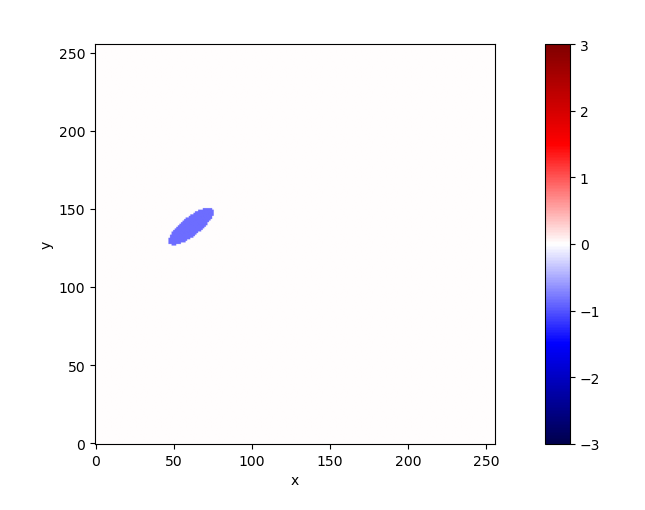

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

C_pred


<IPython.core.display.Javascript object>


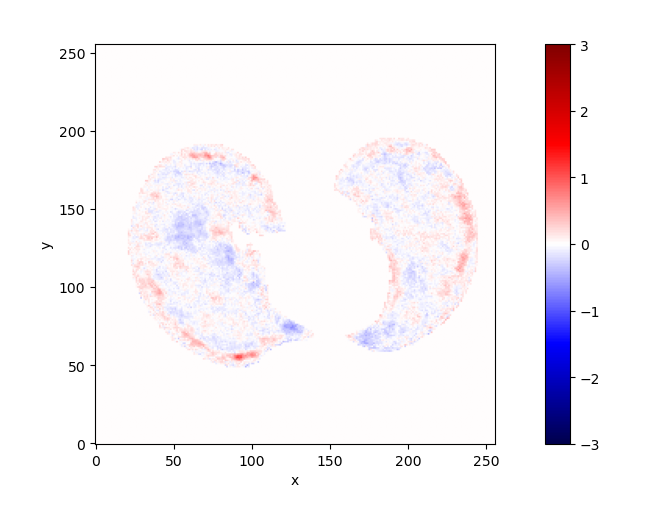

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

CTE


<IPython.core.display.Javascript object>


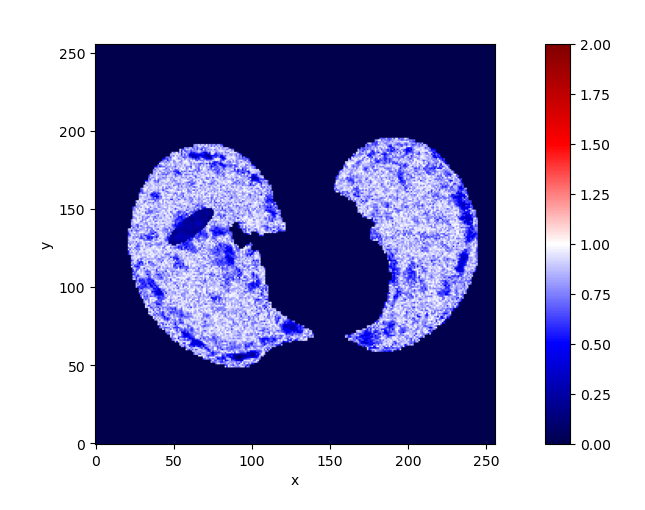

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

0.19546286761760712


In [55]:
%autoreload
import torch

# compute contrast relative to background
eps = 1e-6
C_true_image = torch.log10(E_true_image / E_true_image[mask == 1].median() + eps)
C_pred_image = torch.log10(E_pred_image / E_pred_image[mask == 1].median() + eps)
CTE_image = 10**-(C_pred_image - C_true_image).abs()

z = 45
project.visual.XArrayViewer(
    project.utils.as_xarray( (C_true_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_true'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (C_pred_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='C_pred'),
).update_index(c=0, z=z)

project.visual.XArrayViewer(
    project.utils.as_xarray( (CTE_image) * (mask > 0), dims=['c', 'x', 'y', 'z'], name='CTE'),
).update_index(c=0, z=z)

print(CTE_image[mask > 1].median().item())